## 近距離であることによる反応の抑制化

意見を提出する際に個人として感じることは何か、ということを考えると、他の人が自分と似たような意見を出すのではないか、という点から発言を控えるという場面が考えられる。また、これを代謝系などの化学反応に落とし込んだ際には、このような近い位置の意見はすべて同一の物質を表しているというように考えることもできる。そのように考えれば、似たような性質が縮約されてしまうので全体としての効率が下がってしまうという結果をもたらすのかもしれない。


Note: 化学反応でも同じように1分子での反応とよく混ざった多数の粒子の反応の間でエネルギー的な差に有無があるのかについて調べる必要がある。

これを今まで会議のモデルとして考えてきたものに適応するときには、意見の近いもの(閾値よりも近い距離にある意見)は同じ意見を指すと考え、このような意見は以前に発言されているときには次の発言者はそのような意見は選びにくい、ということを反映したモデルであることが求められる。

具体的なモデルとして、有限個数の意見が状態空間上に分布しているときに、ある閾値$r$よりも近い距離にある点同士をノードでつないでいき、そうして連結されたノードとリンクを一つのクラスターとする。そして意見の選び方は、ある時刻に選ばれた意見から一番近い位置にノードをもつようなクラスターの中から選ぶこととする。このときクラスターの内部でどの意見を選ぶかの規則については、それぞれの人の発言力との関係で決めることにする。一度意見が選ばれたクラスターはもう一度選ばれることはなく、そのためクラスターを作るのに必要なパラメータの値によっては、例3で考えたものと全く同じになることが考えられる。

以上の設定を考えて、シミュレーションを行ってみる。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean as euc
import collections
import operator
import random
import bisect
from itertools import chain
from scipy.optimize import leastsq
from ipython_doctester import test

In [2]:
def uniq_list(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if x not in seen and not seen_add(x)]

def accumulate(iterable, func=operator.add):
    """Return running totals
    
    Usage:
    accumulate([1,2,3,4,5]) --> 1 3 6 10 15
    accumulate([1,2,3,4,5], operator.mul) --> 1 2 6 24 120
    """
    it = iter(iterable)
    total = next(it)
    yield total
    for element in it:
        total = func(total, element)
        yield total

def weighted_choice(d):
    choices, weights = zip(*d)
    cumdist = list(accumulate(weights))
    x = random.random() * cumdist[-1]
    return choices[bisect.bisect(cumdist, x)]

class Person:
    
    def __init__(self, master, id, ideas, w):
        """Initialize argmunets.
        
        Keyword arguments:
        master    : Master class (call from "Meeting")
        self.id   : Id for each person [0, 1, ..., N-1]
        self.ideas: ideas in space [0,1] × [0,1]
        self.w    : probability weight for the person to speak
        """
        self.id = id
        self.ideas = ideas
        self.w = w
        # add_ideas : place, tag : (x, y), [person_id, cluster_id]
        master.ideas += [[(i1, i2), [self.id, 0, self.w]] for i1, i2 in self.ideas]


class Cluster:
    
    def __init__(self, ideas, r):
        """make cluster with self.r
        
        cluster_link:        
        """
        self.ideas = ideas
        self.r = r
        self.l = 0
        self.cluster_link = []
        self.clustering()
        
    def clustering(self):
        self.cell_num = int(1./self.r)
        lr = 1./self.cell_num
        
        self.cell = dict() # key: (cellx,celly), value: list of ids
        self.rcell = []
        for i, idea in enumerate(self.ideas):
            cellx = int(idea[0][0]/lr)
            celly = int(idea[0][1]/lr)
            if self.cell.has_key((cellx, celly)):
                self.cell[(cellx, celly)] += [i]
            else:
                self.cell[(cellx, celly)] = [i]
            self.rcell.append((cellx, celly))
        num = 1
        for i in range(len(self.ideas)):
            num += self.find_nearest(i, num)
        return self.cluster_link

    def find_nearest(self, idea_id, num):
        """find nearest idea

        idea_id: index in self.ideas
        """
        cx, cy = self.rcell[idea_id]
        place = self.ideas[idea_id][0]
        CX = uniq_list([max(0, cx - 1), cx, min(cx + 1, self.cell_num - 1)])
        CY = uniq_list([max(0, cy - 1), cy, min(cy + 1, self.cell_num - 1)])
        tmp = [self.cell[(i, j)] for i in CX for j in CY if self.cell.has_key((i, j))]
        tmp = list(chain.from_iterable(tmp))
        tmp.remove(idea_id)
        if len(tmp) == 0:
            self.ideas[idea_id][1][1] = num
            return 1
        
        nearest = []
        cid = [num]
        for k in tmp:
            if euc(self.ideas[k][0], place) > self.r:
                continue
            nearest.append(k)
            prenum = self.ideas[k][1][1]
            if prenum == 0:
                cid.append(num)
                self.cluster_link.append((idea_id, k))
            elif prenum < num:
                cid.append(prenum)
                if not (k, idea_id) in self.cluster_link:
                    self.cluster_link.append((idea_id, k))
        self.l += len(nearest)
        cluster_id = min(cid)
        if cluster_id < num:
            ans = 0
        else:
            ans = 1
        self.ideas[idea_id][1][1] = cluster_id
        for i in nearest:
            self.ideas[i][1][1] = cluster_id
        cid.remove(num)
        if len(cid) == 0:
            return ans
        cid.remove(cluster_id)
        if len(cid) == 0:
            return ans
        for i in cid:
            for x in self.ideas:
                if x[1][1] == i:
                    x[1][1] = cluster_id
        return ans

        
class Meeting:
    
    def __init__(self, K, N, S=20, r=0.06, draw=True):
        self.K = K
        self.N = N
        self.S = S
        self.r = r
        self.ideas = []
        self.minutes = []
        self.ave_l = 0
        self.draw = draw
        
    def gather_people(self, ideass=None, weights=None):
        """Gather participants.
        
        Keyword arguments:
        ideas  : list of ideas for each person
               ex) [((0.3,0.1),(0.2,0.5)), ((0.5,0.6))] when N = 2
        weights: list of weights for the probability of the person to speak
        """
        if not ideass:
            x = np.random.rand(self.N, self.S*2)
            ideass = []
            for _x in x:
                ideass.append([(i,j) for i,j in zip(_x[::2], _x[1::2])])
        if not weights:
            weights = [1.] * self.N
        for i, ideas, w in zip(range(self.N), ideass, weights):
            Person(self, i, ideas, w)

    def init(self):
        self.gather_people()
        cluster = Cluster(self.ideas, self.r)
        self.cluster_link = cluster.cluster_link
        self.ave_l = cluster.l/float(len(self.ideas))
        if self.draw:
            colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
            self.fig = plt.figure(figsize=(9, 9))
            self.ax = self.fig.add_subplot(1, 1, 1)
            self.labels = []
            self.s1 = []
            for idea, tag in self.ideas:
                x = idea[0]
                y = idea[1]
                s = self.ax.scatter(x, y,
                                    c=colors[tag[0]%len(colors)],
                                    alpha=0.2)
                self.s1.append(s)
            data = []
            for link in self.cluster_link:
                ix = self.ideas[link[0]][0][0]
                iy = self.ideas[link[0]][0][1]
                jx = self.ideas[link[1]][0][0]
                jy = self.ideas[link[1]][0][1]
                data += [(ix, jx), (iy, jy), 'k']
            self.ax.plot(*data, alpha=0.5)
            
    def progress(self):
        self.init()
        preidea = self.ideas[np.random.choice(range(len(self.ideas)))]
        self.minutes.append(preidea)
        l = list(self.ideas)
        self.k = 1

        while self.k < self.K + 1:
            
            # remove ideas in the same cluster
            l = [idea for idea in l if idea[1][1] != preidea[1][1]]

            # if no one can speak: meeting ends.
            if len(l) == 0:
                break

            # confirm cluster id which is nearest from the preidea
            distance = [(euc(preidea[0], i[0]), i) for i in l]
            minclusterid = min(distance)[1][1][1]
            
            # gather ideas in the cluster
            tmp = [idea for idea in l if idea[1][1] == minclusterid]
            d = dict()
            for t in tmp:
                d[t[1][0]] = d.get(t[1][0], 0) + t[1][2]
            d = [(k, v) for k, v in d.items()]
            # chose whose ideas to be chosed from the cluster
            whois = weighted_choice(d)
            
            # gather ideas
            who = [idea for idea in tmp if idea[1][0] == whois]
            p = [(idea, idea[1][2]) for idea in who]
            # chose the next idea from the id is "whois"
            idea = weighted_choice(p)

            self.minutes.append(idea)
            preidea = idea
            self.callback()
            self.k += 1
        self.after()

    def callback(self):
        if self.draw:
            ix = self.minutes[-2][0][0]
            iy = self.minutes[-2][0][1]
            jx = self.minutes[-1][0][0]
            jy = self.minutes[-1][0][1]
            l1 = self.ax.plot([ix, jx], [iy, jy], color='b', alpha=0.5)
            self.ax.text((ix+jx)/2, (iy+jy)/2, self.k)
        else:
            pass

    def after(self):
        if self.draw:
            plt.show()
        else:
            pass

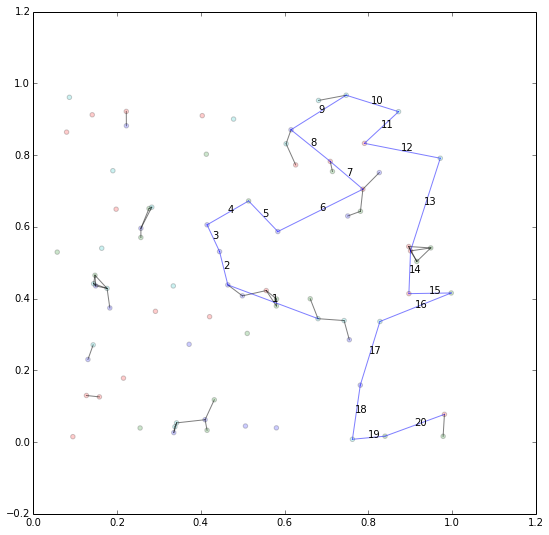

In [4]:
meeting = Meeting(K=20, N=4, S=20, r=0.07, draw=True)
meeting.progress()

In [27]:
print sorted([x[1][1] for x in meeting.minutes])
print meeting.cluster_link
print meeting.ave_l
sorted([(x[1][1], x[1][0], (x[0])) for x in meeting.ideas])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 15, 16, 18, 19, 20, 21, 22, 23, 25, 26]
[(0, 36), (1, 77), (1, 44), (1, 76), (1, 56), (3, 17), (3, 41), (4, 75), (5, 26), (6, 16), (6, 22), (6, 50), (6, 52), (8, 71), (8, 29), (8, 67), (9, 53), (9, 58), (9, 59), (10, 29), (10, 67), (10, 51), (10, 62), (11, 68), (11, 19), (12, 13), (14, 44), (15, 37), (16, 22), (16, 33), (16, 50), (17, 41), (18, 47), (18, 48), (20, 22), (20, 52), (21, 35), (21, 43), (21, 37), (21, 64), (21, 57), (22, 33), (22, 50), (23, 55), (25, 46), (25, 49), (27, 79), (27, 69), (27, 38), (28, 32), (29, 71), (29, 67), (30, 53), (30, 56), (30, 61), (30, 58), (31, 73), (34, 35), (34, 43), (35, 43), (35, 57), (37, 64), (38, 60), (40, 52), (40, 64), (42, 63), (43, 57), (44, 76), (45, 62), (46, 66), (47, 48), (47, 49), (49, 77), (50, 52), (53, 56), (53, 61), (53, 58), (56, 76), (56, 61), (58, 61), (58, 59), (64, 65), (66, 72), (67, 71), (69, 79), (76, 77)]
2.15


[(1, 0, (0.58305849701185908, 0.0065672793403510621)),
 (1, 1, (0.63556992221863751, 0.013349360088383833)),
 (2, 0, (0.012157053566754894, 0.75727817201490266)),
 (2, 0, (0.2351603770655003, 0.73920282012402594)),
 (2, 0, (0.30144765521187888, 0.64125127743844168)),
 (2, 0, (0.468334356871975, 0.81841594998583134)),
 (2, 1, (0.12836323592400256, 0.87352836302183023)),
 (2, 1, (0.36109366036959678, 0.79571675377114981)),
 (2, 2, (0.0075930654110032414, 0.75552909740173024)),
 (2, 2, (0.0196492535475421, 0.78785291837114535)),
 (2, 2, (0.090058319993853164, 0.96546756424205615)),
 (2, 2, (0.11514856769491255, 0.80476189342370619)),
 (2, 2, (0.25724072936153952, 0.6955390806700319)),
 (2, 2, (0.30492094282728943, 0.80114777996368258)),
 (2, 2, (0.38794351041055619, 0.80613914259444419)),
 (2, 2, (0.41854067337289347, 0.84245775698689274)),
 (2, 2, (0.48748341366974868, 0.84693488590492316)),
 (2, 3, (0.00021893977517639662, 0.89070057494529042)),
 (2, 3, (0.052898700508370644, 0.94285611

下のやり方ではクラスターの数をちゃんと数えたことにならない。(クラスター同士の融合を考えることができない)

In [28]:
max([x[1][1] for x in meeting.ideas])

26

正しい数え方

In [29]:
len(uniq_list([x[1][1] for x in meeting.ideas]))

22

閾値$r$を変えたときに意見の総数に対するクラスターの数との関係。横軸$r$、縦軸$1- (\text{クラスターの数})/(\text{意見の総数})$の通常のプロット(上段)と両対数プロット(下段)。

In [13]:
trial = 100

r = np.logspace(-2, np.log10(0.2), num=50)
phi1 = []
for _r in r:
    _phi = 0.
    for t in range(trial):
        meeting = Meeting(K=50, N=6, r=_r, draw=False)
        meeting.init()
        _phi += len(uniq_list([x[1][1] for x in meeting.ideas]))/float(len(meeting.ideas))
    phi1.append(1 - _phi/trial)

In [4]:
def myplot1(x, y, xfit=np.array([]), yfit=np.array([]), param=None,
            scale=['linear', 'linear', 'log', 'log']):
    """my plot function
    
    x: {'label_x', xdata}
    y: {'label_y', ydata}
    param: {'a': 10, 'b': 20}
    """
    if param:
        s = [r'$%s = %f$' % (k, v) for k, v in param.items()]
        label = s[0]
        for _s in s[1:]:
            label += ", " + _s
    label_x, xdata = x.items()[0]
    label_y, ydata = y.items()[0]
    fig = plt.figure(figsize=(8, 12))
    ax1 = fig.add_subplot(211)

    ax1.plot(xdata, ydata)
    if len(xfit):
        ax1.plot(xfit, yfit, label=label)
        ax1.legend(loc='best')
    ax1.set_xlabel(label_x)
    ax1.set_ylabel(label_y)
    ax1.set_xscale(scale[0])
    ax1.set_yscale(scale[1])
    
    ax2 = fig.add_subplot(212)
    ax2.plot(xdata, ydata)
    if len(xfit):
        ax2.plot(xfit, yfit, label=label)
        ax2.legend(loc='best')
    ax2.set_xlabel(label_x)
    ax2.set_ylabel(label_y)
    ax2.set_xscale(scale[2])
    ax2.set_yscale(scale[3])
    plt.show()

In [33]:
def myfit(fit_func, parameter, x, y, xmin, xmax):
    """my fitting and plotting function.
    
    fit_func: function (parameter(type:list), x) 
    parameter: list of tuples: [('param1', param1), ('param2', param2), ...]
    x, y: dict
    xmin, xmax: float
    """
    xkey, xdata = x.items()[0]
    ykey, ydata = y.items()[0]

    def fit(parameter, x, y):
        return y - fit_func(parameter, x)

    # use x : xmin < x < xmax
    i = 0
    while xdata[i] < xmin:
        i += 1
    imin, imax = i, i
    while xdata[i] < xmax:
        i += 1
    imax = i - 1

    paramdata = [b for a, b in parameter]
    paramkey = [a for a, b in parameter]
    res = leastsq(fit, paramdata, args=(xdata[imin:imax], ydata[imin:imax]))
    for p in res[0]:
        print xkey + ": " + str(p)
    fitted = fit_func(res[0], xdata[imin:imax])

    fittedparam = dict([(k, v) for k, v in zip(paramkey, res[0])])
    myplot1(x, y, xdata[imin:imax], fitted, param=fittedparam)

In [34]:
param = [('a', 1.5), ('b', 0.)]
xmin, xmax = 0., 0.07
x = {r'$r$': r}
y = {r'$\phi$': phi1}
def fit_func(parameter, x):
    a = parameter[0]
    b = parameter[1]
    return np.power(x, a)*np.power(10, b)
myfit(fit_func, param, x, y, xmin, xmax)

$r$: 1.73018673432
$r$: 1.81957023866


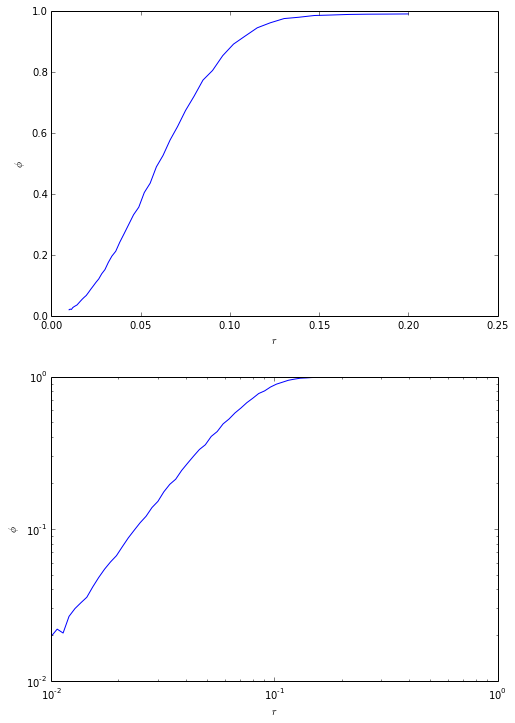

In [18]:
myplot1({r'$r$': r}, {r'$\phi$': phi1})

このグラフから、クラスターの作り方に関する閾値$r$に関してクラスターの数との関係を見ることができる。$r$が大きくなるほどクラスターができやすく、またクラスター同士の融合も起こりやすいため、$r=0.15$ほどで系の中にあるクラスターの数は1となって、すべてが同じクラスター内に所属することになる。

両変数を対数にした状態で直線としてフィットしてみる。得られたパラメータによるフィッティング関数のプロットは、元の状態に戻してから行う。後に示す直接べき関数として求めた場合に比べて、$r$の小さい領域での直線の傾きがよく合っているように見える。

傾き: 1.86089133868
切片: 2.00299872509


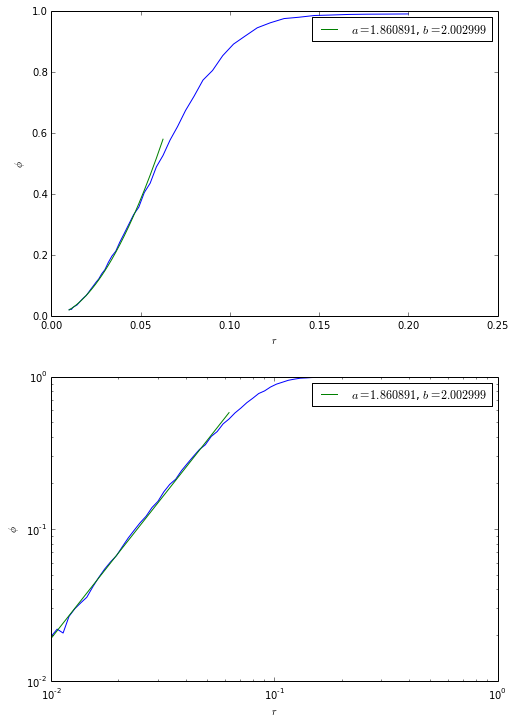

In [19]:
a = 1.5
b = 0.
param = [a, b]
rmin, rmax = 0., 0.07

def fit_func(parameter, x):
    a = parameter[0]
    b = parameter[1]
    return a*np.log10(x) + b

def fit(parameter, x, y):
    return np.log10(y) - fit_func(parameter, x)

i = 0
while r[i] < rmin:
    i += 1
imin, imax = i, i
while r[i] < rmax:
    i += 1
imax = i - 1

res = leastsq(fit, param, args=(r[imin:imax], phi1[imin:imax]))
print u"傾き: " + str(res[0][0])
print u"切片: " + str(res[0][1])
R1 = np.power(10, fit_func(res[0], r[imin:imax]))

myplot1({r'$r$': r}, {r'$\phi$': phi1}, r[imin:imax], R1, param={'a': res[0][0], 'b': res[0][1]})

両変数をそのまま用い、ベキ関数で最小2乗法でフィッティングした場合。先の場合に比べて、$r$の小さい領域で直線とデータの間の差は大きく見える。これは$r$の小さい時にはその差も小さくなっているために、エラーの値としては小さくなっているために起こっていることだと思われる。

傾き: 1.72659903811
切片: 1.81357538307


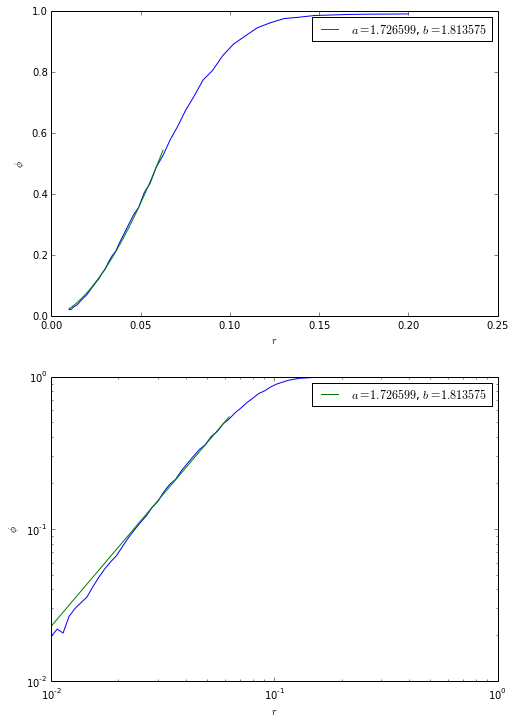

In [20]:
a = 1.5
b = 0.
param = [a, b]
rmin, rmax = 0., 0.07

def fit_func(parameter, x):
    a = parameter[0]
    b = parameter[1]
    return np.power(x, a)*np.power(10, b)

def fit(parameter, x, y):
    return y - fit_func(parameter, x)

i = 0
while r[i] < rmin:
    i += 1
imin, imax = i, i
while r[i] < rmax:
    i += 1
imax = i - 1

res = leastsq(fit, param, args=(r[imin:imax], phi1[imin:imax]))
print u"傾き: " + str(res[0][0])
print u"切片: " + str(res[0][1])
R2 = fit_func(res[0], r[imin:imax])

myplot1({r'$r$': r}, {r'$\phi$': phi1}, r[imin:imax], R2, param={'a': res[0][0], 'b': res[0][1]})

S字型の曲線であるので、

$$\rho (L) = \frac{2}{\omega}L \exp \left[ -  \left( \frac{L}{\omega} \right)^{2} \right]$$

を参考にして、この関数系でフィットしてみる。この場合、$r$の比較的大きい領域のデータを含んでもよい。

$$\phi (r) = 1 - \exp \left[ -  \left( \frac{r}{\omega} \right)^{a} \right]$$

としてパラメータ$\omega$に関して最小2乗法でフィッティングを行う。

omega: 0.0710580799788
a: 2.09805559422


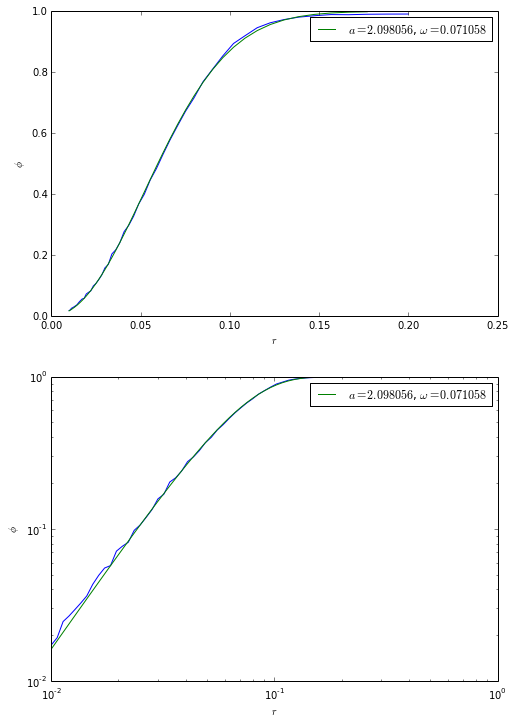

In [16]:
omega = 0.06
a = 2.0
param = [omega, a]
rmin, rmax = 0.01, 0.2

def fit_func(parameter, x):
    omega = parameter[0]
    a = parameter[1]
    return 1 - np.exp(-(x/omega)**a)

def fit(parameter, x, y):
    return y - fit_func(parameter, x)

i = 0
while r[i] < rmin:
    i += 1
imin, imax = i, i
while r[i] < rmax:
    i += 1
imax = i - 1

res = leastsq(fit, param, args=(r[imin:imax], phi1[imin:imax]))
print u"omega: " + str(res[0][0])
print u"a: " + str(res[0][1])
R3 = fit_func(res[0], r[imin:imax])

myplot1({r'$r$': r}, {r'$\phi$': phi1}, r[imin:imax], R3, param={'\omega': res[0][0], 'a': res[0][1]})

また、シグモイド関数の一般形としてのロジスティック関数

$$f(x) = \frac{K}{1+\exp \left[ rK(x_{0}-x)\right]}$$

に関してもフィッティングしてみる。

K: 0.981918027574
r: 58.6818506045
x0: 0.0601203071207


-c:11: RuntimeWarning: overflow encountered in exp


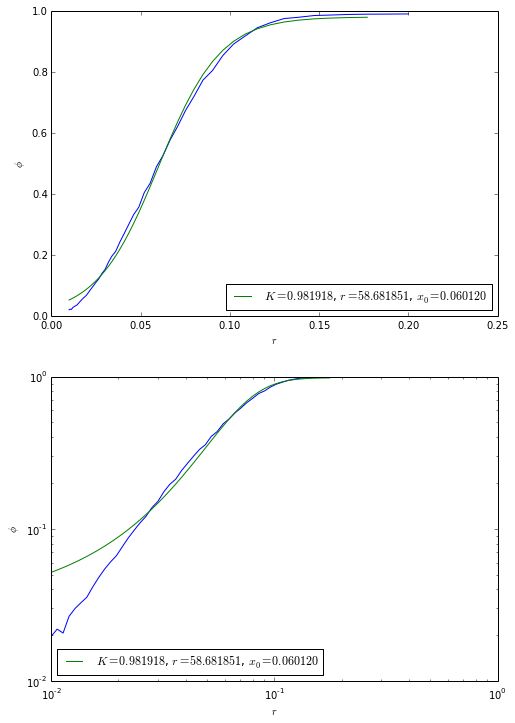

In [23]:
K = 1.
_r = 1.
x0 = 0.
param = [K, _r, x0]
rmin, rmax = 0.01, 0.2

def fit_func(parameter, x):
    K = parameter[0]
    _r = parameter[1]
    x0 = parameter[2]
    return K/(1+np.exp(_r*K*(x0-x)))

def fit(parameter, x, y):
    return y - fit_func(parameter, x)

i = 0
while r[i] < rmin:
    i += 1
imin, imax = i, i
while r[i] < rmax:
    i += 1
imax = i - 1

res = leastsq(fit, param, args=(r[imin:imax], phi1[imin:imax]))
print u"K: " + str(res[0][0])
print u"r: " + str(res[0][1])
print u"x0: " + str(res[0][2])
R4 = fit_func(res[0], r[imin:imax])

myplot1({r'$r$': r}, {r'$\phi$': phi1}, r[imin:imax], R4, param={'K': res[0][0], 'r': res[0][1], 'x_{0}': res[0][2]})

$r$の小さい領域ではフィットは良くないように見える。

### $r$を固定して参加者の人数を変更したときのクラスター数と意見の総数に対するクラスターの数との関係

横軸を参加者の数$N$、縦軸を$1-(\text{クラスタ数}/\text{総意見数})$としたときのグラフを書いてみることにする。

In [25]:
trial = 100

N = np.arange(1, 20)
phi6 = []
for _N in N:
    _phi = 0.
    for t in range(trial):
        meeting = Meeting(K=50, N=_N, r=0.07, draw=False)
        meeting.init()
        _phi += len(uniq_list([x[1][1] for x in meeting.ideas]))/float(len(meeting.ideas))
    phi6.append(1 - _phi/trial)

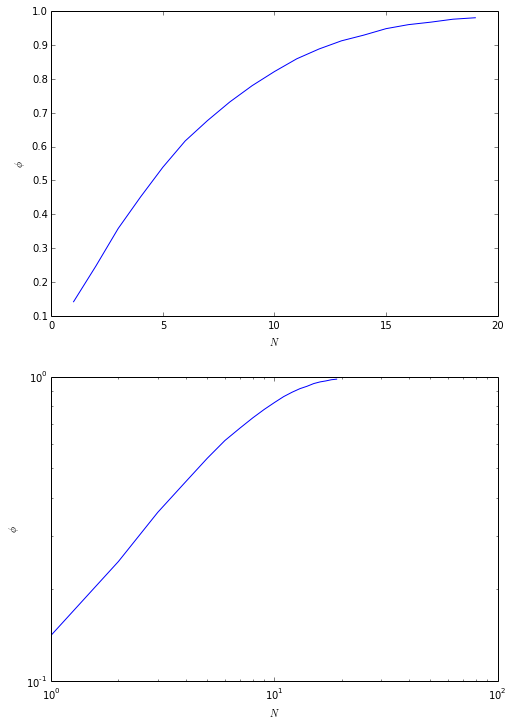

In [26]:
myplot1({r'$N$': N}, {r'$\phi$': phi6})

このとき、意見の総数と参加者の数、一人あたりの意見の数の間には比例の関係が成り立っており、この数のみに依存して、どちらを変えるかは問題ではない。したがって、より刻みを多く取ることのできる一人あたりの意見の数$S$を変えて計算した場合を見てみることにする。

In [3]:
trial = 100

S = np.arange(10, 70)
phi7 = []
for _S in S:
    _phi = 0.
    for t in range(trial):
        meeting = Meeting(K=50, S=_S, N=6, r=0.07, draw=False)
        meeting.init()
        _phi += len(uniq_list([x[1][1] for x in meeting.ideas]))/float(len(meeting.ideas))
    phi7.append(1 - _phi/trial)

In [5]:
myplot1({r'$S$': S}, {r'$\phi$': phi7})

グラフの形から、

$$\phi(S) = 1- \exp\left[- \left( \frac{S}{\omega} \right)^{a}\right]$$

であるとしてフィッティングを行ってみる。

omega: 20.6143107436
a: 1.17886589316


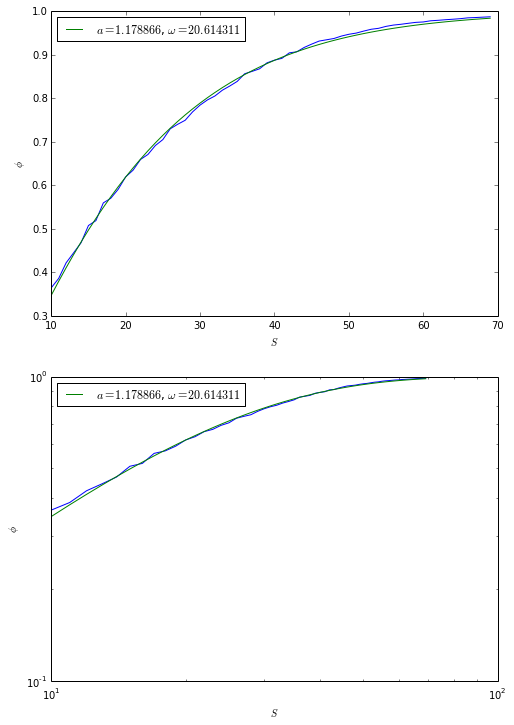

In [12]:
omega = 20.
a = 1.
param = [omega, a]

def fit_func(parameter, x):
    omega = parameter[0]
    a = parameter[1]
    return 1. - np.exp(-(x/omega)**a)

def fit(parameter, x, y):
    return y - fit_func(parameter, x)

res = leastsq(fit, param, args=(S, phi7))
print u"omega: " + str(res[0][0])
print u"a: " + str(res[0][1])
R5 = fit_func(res[0], S)

myplot1({r'$S$': S}, {r'$\phi$': phi7}, S, R5, param={r'\omega': res[0][0], r'a': res[0][1]})

### パーコレーション閾値での振る舞い

また、パーコレーションとしてこの現象をとらえたとき、ある$r$の値において系のサイズと同程度の大きさのクラスターが出現するようになり、このときのクラスターのサイズ分布を求めれば、それはべき分布に従うことが予想される。

以下のセルでそのことを調べてみる。

In [178]:
trial = 1000
_r = 0.07
_phi = collections.Counter()
for i in range(trial):
    meeting = Meeting(K=50, N=6, r=_r, draw=False)
    meeting.init()
    _phi = _phi + collections.Counter([x[1][1] for x in meeting.ideas])
phi = [(k, v/float(trial)) for k, v in dict(_phi).items()]
print phi

[(1, 5.262), (2, 4.921), (3, 4.607), (4, 4.615), (5, 4.118), (6, 4.118), (7, 4.061), (8, 3.678), (9, 3.718), (10, 3.555), (11, 3.392), (12, 3.334), (13, 3.172), (14, 2.841), (15, 2.959), (16, 2.902), (17, 2.723), (18, 2.633), (19, 2.573), (20, 2.461), (21, 2.429), (22, 2.313), (23, 2.184), (24, 2.295), (25, 2.084), (26, 2.034), (27, 2.091), (28, 1.971), (29, 1.801), (30, 1.872), (31, 1.732), (32, 1.684), (33, 1.662), (34, 1.592), (35, 1.543), (36, 1.567), (37, 1.533), (38, 1.455), (39, 1.436), (40, 1.362), (41, 1.357), (42, 1.313), (43, 1.249), (44, 1.156), (45, 1.117), (46, 1.02), (47, 0.908), (48, 0.777), (49, 0.667), (50, 0.559), (51, 0.472), (52, 0.349), (53, 0.241), (54, 0.19), (55, 0.126), (56, 0.077), (57, 0.056), (58, 0.037), (59, 0.019), (60, 0.013), (61, 0.005), (62, 0.003), (63, 0.001), (64, 0.001), (65, 0.001), (66, 0.001), (67, 0.001), (68, 0.001)]


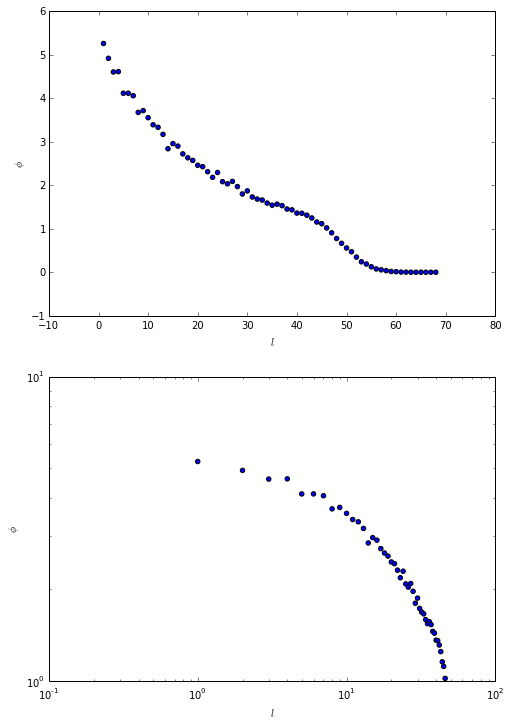

In [179]:
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(211)
ax.scatter([x[0] for x in phi], [x[1] for x in phi])
ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$\phi$')
ax.set_xscale('linear')
ax.set_yscale('linear')
ax = fig.add_subplot(212)
ax.scatter([x[0] for x in phi], [x[1] for x in phi])
ax.set_xlabel(r'$l$')
ax.set_ylabel(r'$\phi$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

閾値$r$を変えたときの最大クラスターのサイズと全要素数との間の関係。クラスターサイズとはここでは同じクラスター内に含まれる要素の数。

横軸$r$、縦軸$(\text{最大クラスターサイズ})/(\text{全要素数})$

In [9]:
print collections.Counter([x[1][1] for x in meeting.ideas])
max([v for v in collections.Counter([x[1][1] for x in meeting.ideas]).values()])/float(len(meeting.ideas))

Counter({12: 6, 15: 6, 27: 6, 2: 5, 19: 5, 25: 4, 8: 3, 10: 3, 16: 3, 20: 3, 26: 3, 30: 3, 38: 3, 1: 2, 3: 2, 5: 2, 6: 2, 7: 2, 11: 2, 18: 2, 32: 2, 37: 2, 42: 2, 47: 2, 50: 2, 51: 2, 4: 1, 9: 1, 13: 1, 14: 1, 17: 1, 21: 1, 22: 1, 23: 1, 28: 1, 29: 1, 31: 1, 33: 1, 34: 1, 35: 1, 36: 1, 39: 1, 40: 1, 41: 1, 43: 1, 44: 1, 45: 1, 46: 1, 48: 1, 49: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1})


0.05

In [29]:
trial = 100

r = np.linspace(0.01, 0.2, num=50)
phi2 = []
for _r in r:
    _phi = 0.
    for t in range(trial):
        meeting = Meeting(K=50, N=6, r=_r, draw=False)
        meeting.init()
        _phi += max([v for v in
                     collections.Counter([x[1][1] for x in meeting.ideas]).values()]
                    ) \
                / \
                float(len(meeting.ideas))
    phi2.append(_phi/trial)

In [35]:
def myplot2(x, y, xfit=np.array([]), yfit=np.array([]), param=None):
    myplot1(x, y, xfit, yfit, param, scale=['linear', 'linear', 'linear', 'log'])

In [36]:
myplot2({r'$r$': r}, {r'$\phi$': phi2})

横軸r、縦軸(最大クラスターサイズ)/(全要素数)で縦軸に対数を取ったときに直線に乗っている(ように見える)。

なぜか?

フィッティング関数として

$$f(x) = 10^{ax + b}$$



In [226]:
a = 10.
b = 20.
param = [a, b, c]
rmin, rmax = 0.01, 0.10

def fit_func(parameter, x):
    a = parameter[0]
    b = parameter[1]
    return np.power(10, a*x + b)

def fit(parameter, x, y):
    return y - fit_func(parameter, x)

i = 0
while r[i] < rmin:
    i += 1
imin, imax = i, i
while r[i] < rmax:
    i += 1
imax = i - 1

res = leastsq(fit, param, args=(r[imin:imax], phi1[imin:imax]))
print u"a: " + str(res[0][0])
print u"b: " + str(res[0][1])
R5 = fit_func(res[0], r[imin:imax])

myplot2(r, phi2, r[imin:imax], R5, res[0])

a: 12.4841338989
b: -1.14418617506


### 解析的アプローチ

点の分布する範囲は$\Omega = [0,1]\times [0,1]$であり、この中の面積$S$の領域の中に点を見出す確率は$S$である。

次に、領域内のある点$\vec x=(x,y)$を中心として半径$r$($0 < r \le 0.5$)の領域$B(\vec x, r)$内に点を見出す確率$p(\vec x)$は、境界の影響をうけない領域($\Omega ' = \{(x,y) | r \le x \le 1-r, r \le y \le 1-r \}$)では$\pi r^{2}$であり、境界の影響を受ける領域($\Omega'' = \Omega / \Omega'$)において点を見出す確率は、領域を

$$\begin{align}
\Omega''_{x} &= \{(x,y) | 0 \le x < r, r< y < 1-r\} \\
\Omega''_{1-x} &= \{(x,y) | 1-r < x \le 1, r< y < 1-r\} \\
\Omega''_{y} &= \{(x,y) | r < x < 1-r, 0 \le y < r\} \\
\Omega''_{1-y} &= \{(x,y) | r < x < 1-r, 1-r < y \le 1\} \\
\Omega''_{x,y} &= \{(x,y) | 0 \le x < r, 0 \le y < r\} \\
\Omega''_{1-x,y} &= \{(x,y) | 1-r < x \le 1, 0 \le y < r\} \\
\Omega''_{x,1-y} &= \{(x,y) | 0 \le x < r, 1-r < y \le 1\} \\
\Omega''_{1-x, 1-y} &= \{(x,y) | 1-r < x \le 1, 1-r < y \le 1\}
\end{align}$$

のようにあらわし、$\Omega''_{i} = \{\Omega''_{x}, \Omega''_{1-x}, \Omega''_{y}, \Omega''_{1-y}$\}、また$\Omega''_{i,j} = \{\Omega''_{x,y}, \Omega''_{1-x,y}, \Omega''_{x,1-y}, \Omega''_{1-x,1-y}\}$でまとめて書くことにすると、

$$p(\vec x \in \Omega''_{i}) = i \sqrt{r^{2}-i^{2}} + r^{2} \left[ \pi -\arccos \frac{i}{r} \right]$$

$$\begin{align}p(\vec x \in \Omega''_{i,j}) = &\frac{1}{2}\left\{ \sqrt{r^{2}-i^{2}} + \min \left(j, \sqrt{r^{2}-i^{2}}\right) \right\}i + \frac{1}{2}\left\{ \sqrt{r^{2}-j^{2}} + \min \left( i, \sqrt{r^{2}-j^{2}}\right) \right\}j \\
&+ \frac{1}{2}r^{2} \left\{ 2\pi -\arccos \frac{i}{r}-\arccos \frac{j}{r}-\min \left( \frac{\pi}{2}, \arccos \frac{i}{r} +\arccos \frac{j}{r} \right) \right\}
\end{align}$$

のようにあらわすことができる。

確率$p$をすべての領域について積分した値は、領域$\Omega$から一様乱数によって一つの点を選び、その点を中心とした$r$による範囲に1つの点を見出す確率の期待値となる。

この確率を$p'(r)$とし、$0\le r \le 0.5$のときは

$$p'(r) = p'(r)_{\Omega''} + 4p'(r)_{\Omega''_{i}} + 4p'(r)_{\Omega''_{i,j}}$$

とできる。それぞれの領域について積分を実行する。

$$p'(r)_{\Omega'} = \int_{r}^{1-r} \int_{r}^{1-r}\pi r^{2}\mathrm{d}x\mathrm{d}y = (1-2r)^{2}\pi r^{2}$$

$$\begin{align}
p'(r)_{\Omega'_{i}} = p'(r)_{\Omega'_{x}} &= \int_{0}^{r} \int_{r}^{1-r}\mathrm{d}x\mathrm{d}y\ x\sqrt{r^{2}-x^{2}} + r^{2}\left[\pi - \arccos\frac{x}{r}\right]\\
&= (1-2r)\left\{ \frac{r^{3}}{3} + r^{2}\pi\cdot r - r^{2}\cdot r \right\}\\
&= (1-2r)r^{3}\left( \pi-\frac{2}{3} \right)
\end{align}$$

NOTE1:

$$\begin{align}
&\int_{0}^{r}\mathrm{d}x\ x\sqrt{r^{2}-x^{2}} \\
&\ \ \ \ \ \left[x = r\cos \theta \right]\\
&= \int_{\frac{\pi}{2}}^{0}\mathrm{d}\theta\ (-r\sin\theta)\ r\cos\theta\ r\sin\theta\\
&= r^{3}\left[ \frac{\sin^{3}\theta}{3}\right]^{\frac{\pi}{2}}_{0} \\
&= \frac{r^{3}}{3}
\end{align}$$

NOTE2:

$x = \cos t \ (0< t< \pi)$とすると
$$\frac{\mathrm{d}x}{\mathrm{d}t} = - \sin t < 0$$

$t = \arccos x$であるから、

$$\begin{align}
\frac{\mathrm{d}}{\mathrm{d}x}\arccos x &= \frac{1}{\frac{\mathrm{d}}{\mathrm{d}t}\cos t} = -\frac{1}{\sin t}\\
&=- \frac{1}{\sqrt{\sin^{2}t}} = - \frac{1}{\sqrt{1- \cos^{2}t}} \\
&= - \frac{1}{\sqrt{1- x^{2}}}
\end{align}$$

したがって、

$$\begin{align}
\int \arccos x \mathrm{d}x\  &= x\arccos x + \int \frac{x}{\sqrt{1-x^{2}}}\mathrm{d}x\\
&=x\arccos x - \sqrt{1-x^{2}} + C
\end{align}$$

($C$は積分定数)

今の場合、

$$\begin{align}
\int^{r}_{0} \arccos \frac{x}{r} \mathrm{d}x &= \int^{1}_{0}\arccos t \cdot r\mathrm{d}t\\
&= r \left[ t \arccos t - \sqrt{1-t^{2}} \right]^{1}_{0}\\
&= r ( 1\arccos1 -\sqrt{1-1} - 0 \arccos0 + \sqrt{1-0})\\
&= r
\end{align}$$

$p'(r)_{\Omega''_{i,j}}$を以下のように分解してそれぞれ計算する。

$$\begin{align}
p'(r)_{\Omega''_{i,j}} &= p'(r)_{\Omega''_{x, y}}\\
&= p'(r)_{\Omega''_{x, y}1}  +p'(r)_{\Omega''_{x, y}2}\\
&= p'(r)_{\Omega''_{x, y}1'} - p'(r)_{\Omega''_{x, y}1''} + p'(r)_{\Omega''_{x, y}2}
\end{align}$$

$$\begin{align}
p'(r)_{\Omega''_{x,y}1'} &= \int^{r}_{0}\int^{r}_{0}\mathrm{d}x\mathrm{d}y\ x\sqrt{r^{2}-x^{2}} + y \sqrt{r^{2} -y^{2}} + \frac{1}{2}r^{2}\left( 2\pi -2\arccos\frac{x}{r} -2\arccos\frac{y}{r} \right) \\
&= r\int^{r}_{0}\mathrm{d}x\ \left\{x\sqrt{r^{2}-x^{2}} - r^{2}\arccos\frac{x}{r} \right\} 
+ r\int^{r}_{0}\mathrm{d}x\ \left\{x\sqrt{r^{2}-x^{2}} - r^{2}\arccos\frac{x}{r} \right\} + \pi r^{2}\cdot r^{2}\\
&= r\left( \frac{r^{3}}{3} -r^{3} \right) + r\left( \frac{r^{3}}{3} -r^{3} \right) + \pi r^{4}\\
&=  \left(\pi -\frac{4}{3}\right)r^{4}
\end{align}$$

$$\begin{align}
p'(r)_{\Omega''_{x,y}1''} &= \int^{r}_{0}\int^{\sqrt{r^{2}-x^{2}}}_{0}\mathrm{d}x\mathrm{d}y\ \left[ x\sqrt{r^{2}-x^{2}} + y \sqrt{r^{2} -y^{2}} + r^{2}\left(\pi -\arccos\frac{x}{r} -\arccos\frac{y}{r}\right) \right]\\
&= \int^{r}_{0}\mathrm{d}x\left[ \left\{ x\sqrt{r^{2}-x^{2}} + r^{2}\pi -r^{2}\arccos\frac{x}{r} \right\}\sqrt{r^{2}-x^{2}} + \int^{\sqrt{r^{2}-x^{2}}}_{0}\mathrm{d}y\ y\sqrt{r^{2}-y^{2}} -r^{2}\arccos\frac{y}{r}\right]\\
&= \int^{r}_{0}\mathrm{d}x\left[ x(r^{2}-x^{2}) + r^{2}\pi\sqrt{r^{2}-x^{2}} -r^{2}\arccos \frac{x}{r} \sqrt{r^{2}-x^{2}} + \frac{r^{3}}{3} - \frac{x^{3}}{3} - r^{2}\frac{\pi}{2}\sqrt{r^{2}-x^{2}} + r^{2}\arccos\frac{x}{r}\sqrt{r^{2}-x^{2}} +r^{2}x - r^{3}\right] \\
&= \int^{r}_{0}\mathrm{d}x \left[-\frac{4}{3}x^{3} + 2r^{2}x - \frac{2}{3}r^{3} + \frac{\pi}{2}r^{2}\sqrt{r^{2}-x^{2}} \right]\\
&= \left[ -\frac{4}{3}\frac{x^{4}}{4} + r^{2}x^{2} - \frac{2}{3}r^{3}x \right]^{r}_{0} + \frac{\pi}{2}r^{2}\cdot \frac{1}{4}\pi r^{2}\\
&= -\frac{r^{4}}{3} + r^{4} -\frac{2}{3}r^{4} + \frac{\pi ^{2}}{8}r^{4}\\
&= \frac{\pi^{2}}{8}r^{4}
\end{align}$$

NOTE1:

$y=r\cos \theta$とおく。

$y$の積分領域$[0, \sqrt{r^{2}-x^{2}}]$は$\theta$の範囲としては$[\pi/2, \theta' = \arcsin(x/r)]$となる。

(図)

$$\begin{align}
\int^{\sqrt{r^{2}-x^{2}}}_{0}\mathrm{d}y\ y\sqrt{r^{2}-y^{2}} &= \int^{\theta'}_{\frac{\pi}{2}}-r^{3}\sin^{2}\theta\ \cos\theta \mathrm{d}\theta\\
&= r^{3}\left[ \frac{\sin^{3}\theta}{3} \right]^{\frac{\pi}{2}}_{\theta'}\\
&= \frac{r^{3}}{3} - r^{3}\frac{\left( \frac{x}{r} \right)^{3}}{3}\\
&= \frac{r^{3}}{3} - \frac{x^{3}}{3}
\end{align}$$

NOTE2:

$t = x/r$とおいて積分する。

$$\begin{align}
r^{2}\int^{\sqrt{r^{2}-x^{2}}}_{0}\mathrm{d}y\ \arccos \frac{y}{r} &= r^{2}\int^{\frac{\sqrt{r^{2}-x^{2}}}{r}}_{0}r\mathrm{d}t\ \arccos t\\
&= r^{3}\left[ t\arccos t - \sqrt{1-t^{2}} \right]^{\frac{\sqrt{r^{2}-x^{2}}}{r}}_{0}\\
&= r^{3}\left[ \frac{\sqrt{r^{2}-x^{2}}}{r}\left( \frac{\pi}{2} - \arcsin \frac{x}{r} \right) - \frac{x}{r} + 1 \right]\\
&= r^{2}\frac{\pi}{2}\sqrt{r^{2}-x^{2}} - r^{2}\sqrt{r^{2}-x^{2}}\arccos\frac{x}{r} - r^{2}x + r^{3}
\end{align}$$

$$\begin{align}
p'(r)_{\Omega''_{x, y}2} &= \int^{r}_{0}\int^{r}_{0}\mathrm{d}x\mathrm{d}y\ \frac{1}{2}x\sqrt{r^{2}-x^{2}} + \frac{1}{2}y\sqrt{r^{2} -y^{2}} + xy + \frac{1}{2}r^{2}\left( 2\pi - \arccos\frac{x}{r} - \arccos\frac{y}{r} - \frac{\pi}{2} \right)\\
&= \int^{r}_{0}\mathrm{d}x\int^{\sqrt{r^{2}-x^{2}}}_{0}\mathrm{d}y\ \frac{1}{2}x\sqrt{r^{2}-x^{2}} + \frac{1}{2}y\sqrt{r^{2} -y^{2}} + xy + \frac{1}{2}r^{2}\left( 2\pi - \arccos\frac{x}{r} - \arccos\frac{y}{r} - \frac{\pi}{2} \right)\\
&= \int^{r}_{0}\mathrm{d}x\left[ \left\{ \frac{1}{2}x\sqrt{r^{2}-x^{2}} + \frac{3}{4}\pi r^{2} - \frac{1}{2}r^{2}\arccos\frac{x}{r} \right\}\sqrt{r^{2}-x^{2}} + \int^{\sqrt{r^{2}-x^{2}}}_{0}\mathrm{d}y\ \frac{1}{2}y\sqrt{r^{2}-y^{2}} + xy - \frac{1}{2}r^{2}\arccos\frac{y}{r}\right]\\
&= \int^{r}_{0}\mathrm{d}x\left[ \frac{1}{2}xr^{2} - \frac{x^{3}}{2} + \frac{3}{4}\pi r^{2}\sqrt{r^{2}-x^{2}} - \frac{1}{2}r^{2}\arccos \frac{x}{r} \sqrt{r^{2}-x^{2}} \right.\\
&\ \ \ \ \ \ \ \ \ \ + \left. \frac{r^{3}}{6} - \frac{x^{3}}{6} + \frac{1}{2}xr^{2} - \frac{x^{3}}{2} - \frac{\pi}{4}r^{2}\sqrt{r^{2}-x^{2}} + \frac{1}{2}r^{2}\arccos\frac{x}{r}\sqrt{r^{2}-x^{2}} + \frac{1}{2}r^{2}x - \frac{r^{3}}{2}\right] \\
&= \int^{r}_{0}\mathrm{d}x\left[- \frac{7}{6}x^{3} - \frac{r^{3}}{3} + \frac{3}{2}r^{2}x + \frac{\pi}{2}r^{2}\sqrt{r^{2}-x^{2}} \right]\\
&= -\frac{7}{24}r^{4} - \frac{r^{4}}{3} + \frac{3}{4}r^{4} + \frac{\pi}{2}r^{2}\cdot \frac{\pi}{4}r^{2}\\
&= \left( - \frac{7}{24} - \frac{1}{3} + \frac{3}{4} + \frac{\pi^{2}}{8}\right)r^{4}\\
&= \left( \frac{\pi^{2}}{8} + \frac{1}{8} \right)r^{4}
\end{align}$$

$$\begin{align}
p'(r)_{\Omega''_{i,j}} &= p'(r)_{\Omega''_{x, y}}\\
&= p'(r)_{\Omega''_{x, y}1}  +p'(r)_{\Omega''_{x, y}2}\\
&= p'(r)_{\Omega''_{x, y}1'} - p'(r)_{\Omega''_{x, y}1''} + p'(r)_{\Omega''_{x, y}2}\\
&= \left(\pi -\frac{4}{3}\right)r^{4} - \frac{\pi^{2}}{8}r^{4} + \left( \frac{\pi^{2}}{8} + \frac{1}{8} \right)r^{4}\\
&= \left(\pi -\frac{29}{24}\right)r^{4}
\end{align}$$

これまでの結果をすべて合わせると、

$$\begin{align}
p'(r) &= p'(r)_{\Omega''} + 4p'(r)_{\Omega''_{i}} + 4p'(r)_{\Omega''_{i,j}}\\
&= (1-2r)^{2}\pi r^{2} + (1-2r)r^{3}\left( 4\pi-\frac{8}{3} \right) + \left(4\pi -\frac{29}{6}\right)r^{4}\\
&= \pi r^{2} - 4\pi r^{3} + 4\pi r^{4} + 4\pi r^{3} -\frac{8}{3}r^{3} - 8\pi r^{4} + \frac{16}{3}r^{4} + 4\pi r^{4} - \frac{29}{6}r^{4}\\
&= \frac{1}{2}r^{4} -\frac{8}{3}r^{3} + \pi r^{2}
\end{align}$$

実際に数えてみる。

In [35]:
trial = 100

r = np.linspace(0.01, 0.5, num=50)
phi3 = []
for _r in r:
    _phi = 0.
    for t in range(trial):
        meeting = Meeting(K=50, N=6, r=_r, draw=False)
        meeting.init()
        _phi += meeting.ave_l
    phi3.append(_phi/trial)

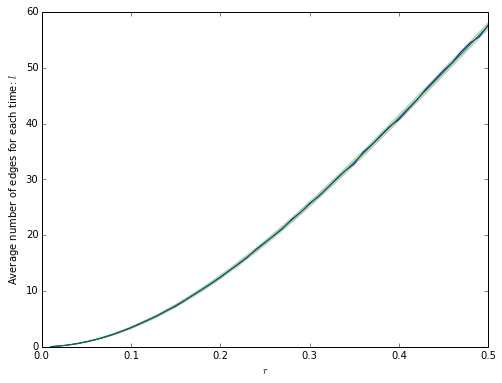

In [37]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

r = np.linspace(0.01, 0.5, num=50)
def func(x):
    return (1./2*x**4 - 8/3.*x**3 + np.pi*x**2)*(120-1)
y = func(r)
def func2(x):
    return np.sqrt((-0.25*x**8 + 8/3.*x**7 - (64/9.+np.pi)*x**6 + 16/3.*np.pi*x**5
                   + (0.5-np.pi**2)*x**4 - 8/3.*x**3 + np.pi*x**2)*(120-1)/(trial))

delta = func2(r)
y1 = y + delta
y2 = y - delta
y3 = np.zeros(50)
y3[y2>0] = y2[y2>0]
ax.fill_between(r, y1, y3, facecolor='green', alpha=0.2)
ax.plot(r, phi3)
ax.plot(r, y)
ax.set_xlabel(r'$r$')
ax.set_ylabel(r"Average number of edges for each time: $l$")
plt.show()

OK

### 平均の頂点間の距離と人数(アイデアの個数)との間の関係

In [6]:
tmp = 0
for p0, p1 in zip(meeting.minutes[:-1], meeting.minutes[1:]):
    tmp += euc(p0[0], p1[0])
ave_dist_btw_nodes = tmp/float(len(meeting.minutes)-1)
print ave_dist_btw_nodes

0.151907351898


In [1]:
import multiprocessing as mp
cp = mp.cpu_count() * 2
pool = mp.Pool

trial = 10

N = np.arange(1, 15)

def wrapper(arg):
    return arg[0](arg[1], arg[2])

def calc_N_phi(N, trial):
    _phi = []
    for t in range(trial):
        meeting = Meeting(K=50, N=_N, r=0.07, draw=False)
        meeting.progress()
        tmp = []
        for p0, p1 in zip(meeting.minutes[:-1], meeting.minutes[1:]):
            tmp.append(euc(p0[0], p1[0]))
        _phi.append(np.average(np.array(tmp)))
    return np.average(np.array(_phi))

jobs = [(calc_N_phi, _N, trial) for _N in N]
phi4 = pool(cp).map(wrapper, jobs)

NameError: name 'np' is not defined

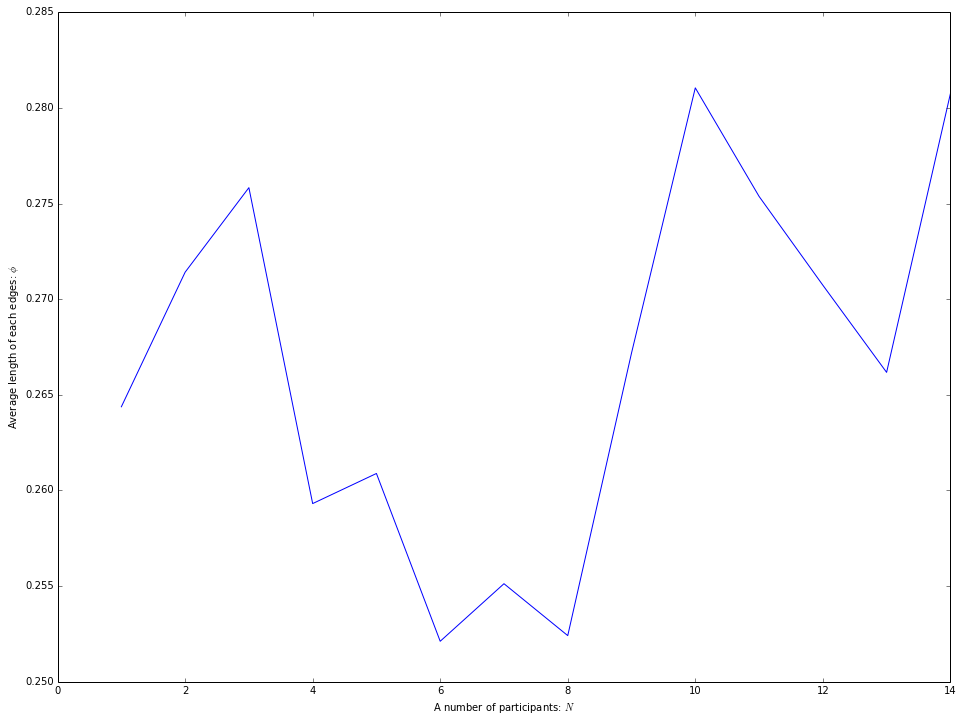

In [6]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)

ax.plot(N, phi4)
ax.set_xlabel(r'A number of participants: $N$')
ax.set_ylabel(r"Average length of each edges: $\phi$")
plt.show()

In [4]:
trial = 1000

S = np.arange(10, 60, 5)
phi5 = []
for _S in S:
    _phi = 0.
    for t in range(trial):
        meeting = Meeting(K=50, N=5, S=_S, r=0.07, draw=False)
        meeting.progress()
        tmp = 0
        for p0, p1 in zip(meeting.minutes[:-1], meeting.minutes[1:]):
            tmp += euc(p0[0], p1[0])
        try:
            result = tmp/float(len(meeting.minutes)-1)
        except ZeroDivisionError:
            result = 0.
        _phi += result
    phi5.append(_phi/trial)

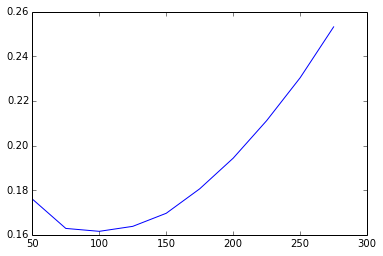

In [6]:
plt.plot(S*5, phi5)
plt.show()

----

In [10]:
import pandas as pd
pd.DataFrame(np.array([r, phi]).T)

0         1
0   0.001000  0.000000
1   0.011474  0.023056
2   0.021947  0.081389
3   0.032421  0.181667
4   0.042895  0.283333
5   0.053368  0.406111
6   0.063842  0.522222
7   0.074316  0.635278
8   0.084789  0.711667
9   0.095263  0.788056
10  0.105737  0.833611
11  0.116211  0.869444
12  0.126684  0.900833
13  0.137158  0.920556
14  0.147632  0.955000
15  0.158105  0.972500
16  0.168579  0.977778
17  0.179053  0.982500
18  0.189526  0.988333
19  0.200000  0.991389

[20 rows x 2 columns]

In [22]:
a = [1,2,3,4,5,6,7]
preidea = np.random.choice(a)
print preidea
print a

5
[1, 2, 3, 4, 5, 6, 7]


In [52]:
ideas = meeting.ideas
r = 0.06
cell_num = int(1./r)
print cell_num
lr = 1./cell_num
print lr
cell = dict()
rcell = []
for i, idea in enumerate(ideas):
    cellx = int(idea[0][0]/lr)
    celly = int(idea[0][1]/lr)
    if cell.has_key((cellx, celly)):
        cell[(cellx, celly)] += [i]
    else:
        cell[(cellx, celly)] = [i]
    rcell.append((cellx, celly))
cell

16
0.0625


{(0, 1): [80],
 (0, 4): [59],
 (0, 5): [11],
 (0, 7): [114],
 (0, 11): [115],
 (0, 13): [78],
 (0, 15): [43, 70, 117],
 (1, 1): [67],
 (1, 6): [8],
 (1, 9): [39],
 (2, 1): [108],
 (2, 2): [113],
 (2, 4): [10],
 (2, 5): [18],
 (2, 7): [63],
 (2, 8): [81],
 (2, 9): [35, 74],
 (2, 13): [48],
 (2, 15): [103],
 (3, 0): [91],
 (3, 4): [4, 42],
 (3, 10): [58, 73],
 (3, 11): [0],
 (3, 15): [96],
 (4, 5): [34],
 (4, 6): [46],
 (4, 9): [16],
 (4, 11): [86],
 (4, 12): [89],
 (5, 2): [75],
 (5, 3): [76, 107],
 (5, 4): [99],
 (5, 9): [28],
 (5, 10): [72],
 (5, 11): [5],
 (5, 12): [51, 53],
 (5, 13): [31],
 (5, 14): [92, 106],
 (5, 15): [102],
 (6, 1): [77, 87],
 (6, 3): [2],
 (6, 6): [50, 112, 116],
 (6, 8): [25],
 (6, 9): [45],
 (6, 13): [22],
 (7, 1): [79],
 (7, 2): [66],
 (7, 3): [64],
 (7, 5): [84],
 (7, 6): [14, 109],
 (7, 7): [19],
 (7, 9): [23],
 (7, 13): [104],
 (7, 14): [1],
 (7, 15): [54],
 (8, 4): [111],
 (8, 7): [20, 62],
 (8, 9): [33],
 (8, 10): [9],
 (8, 11): [94],
 (8, 14): [85],
 (9

In [20]:
cell_num = 14
[[[]]*cell_num]*cell_num

[[[], [], [], [], [], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], [], [], [], [], []]]

In [44]:
@test
def uniq_list(seq):
    """
    >>> a = [1, 2, 5, 6, 7, 3, 2, 0]
    >>> uniq_list(a)
    [1, 2, 5, 6, 7, 3, 0]
    """
    seen = set()
    seen_add = seen.add
    return [x for x in seq if x not in seen and not seen_add(x)]


Success!

In [12]:
def accumulate(iterable, func=operator.add):
    """Return running totals
    
    Usage:
    accumulate([1,2,3,4,5]) --> 1 3 6 10 15
    accumulate([1,2,3,4,5], operator.mul) --> 1 2 6 24 120
    """
    it = iter(iterable)
    total = next(it)
    yield total
    for element in it:
        total = func(total, element)
        yield total


def weighted_choice(d):
    import random
    import bisect

    choices, weights = zip(*d)
    cumdist = list(accumulate(weights))
    x = random.random() * cumdist[-1]
    return choices[bisect.bisect(cumdist, x)]

weighted_choices = [(k,v) for k,v in {'Red': 3, 'Blue': 2, 'Yellow': 1, 'Green': 4}.items()]
weighted_choice(weighted_choices)

'Blue'